In [4]:
import numpy as np
import pandas as pd

from pathlib import Path
from mediapipe import solutions

from utils import *
from data_utils import prepare_dataframe, generate_dataframe
from custom_pose_landmarks import CustomPoseLandmark
from canonical_form import PoseCanonicalForm

import math
import numpy as np

import matplotlib.pyplot as plt

In [5]:
# Selected values of pose landmarks corresponding to PoseLandmark class from MediaPipe library
values = [0, 11, 12, 13, 14, 15, 16, 19, 20, 23, 24, 25, 26, 27, 28, 31, 32]

# Custom pose landmark names
landmarks = {
    'THORAX': ['NOSE'],
    'PELVIS': ['LEFT_HIP', 'RIGHT_HIP'],
}

# MediaPipe solutions
mp_drawing = solutions.drawing_utils
mp_pose = solutions.pose


pose = CustomPoseLandmark(mp_pose, values, landmarks)

In [6]:
import cv2

In [7]:
custom_pose = CustomPoseLandmark(mp_pose, values, landmarks)

source = Path('../data/raw/squat/movie_01.mp4')
dataframe = prepare_dataframe(custom_pose)
dataframe2 = prepare_dataframe(custom_pose)
Id = source.name.split('.')[0]
time = 0 
cap = cv2.VideoCapture(source.__str__())


with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    enable_segmentation=False
) as pose:
    while cap.isOpened():
        ret, image = cap.read()
        if ret:
            time += 1
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            landmark_list = get_custom_landmarks(
                mp_pose=mp_pose,
                custom_pose=custom_pose,
                landmarks=results.pose_landmarks,
                custom_landmarks=list(custom_pose.custom_landmarks.keys()))
        

            record = [Id, time]
            
            # Create record containing video id, actual time and pose landmark coordinates
            for landmark in landmark_list.landmark:
                # Extract pose landmarks coordinates and store as array
                coordinates = landmark2array(landmark)[:3]
                record += coordinates.tolist()

            # Save collected data in DataFrame format
            dataframe = pd.concat(
                [dataframe, pd.DataFrame([record], columns=dataframe.columns)],
                ignore_index=True
            )


            if time == 1:
                # Initialize PoseCanonicalForm class
                canonical = PoseCanonicalForm(
                    mp_pose=mp_pose,
                    custom_pose=custom_pose,
                    landmark_list=landmark_list,
                    default_position=np.array([1, 0, 1]),
                    default_point=np.zeros(shape=(3,)),
                    default_length=0.25
                )
                
            record2 = [Id, time]
            
            # Create record containing video id, actual time and pose landmark coordinates
            for landmark in landmark_list.landmark:
                # Extract pose landmarks coordinates and store as array
                coordinates = landmark2array(landmark)[:3]
                # transform using canonical form transformations
                coordinates = canonical.transform(coordinates)

                record2 += coordinates.tolist()

            # Save collected data in DataFrame format
            dataframe2 = pd.concat(
                [dataframe2, pd.DataFrame([record2], columns=dataframe2.columns)],
                ignore_index=True
            )
            
        else:
            break

cap.release()
cv2.destroyAllWindows()

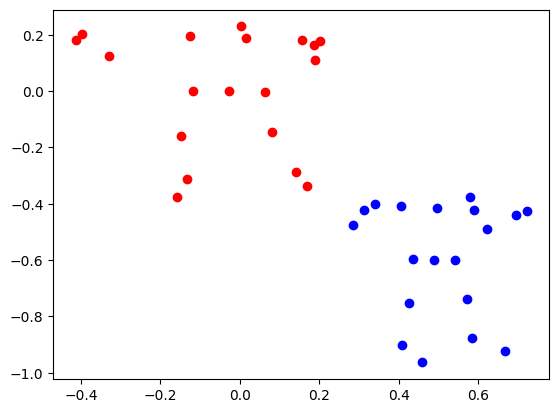

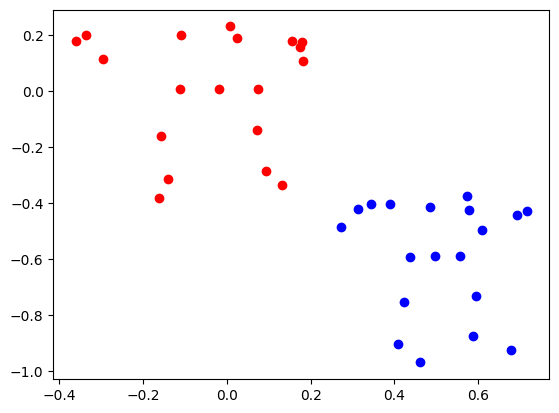

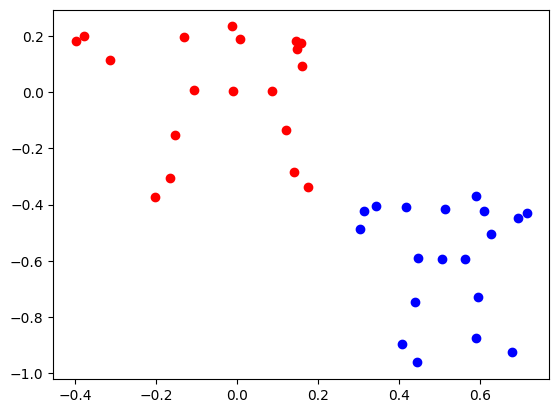

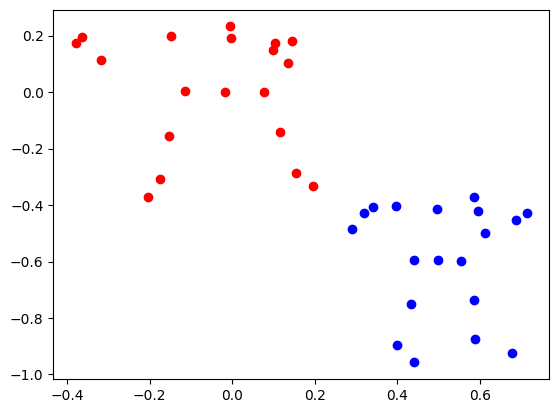

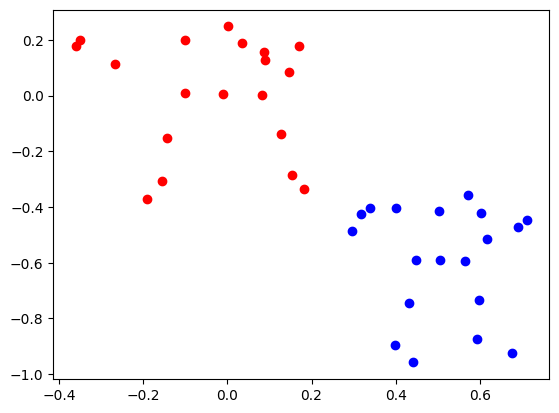

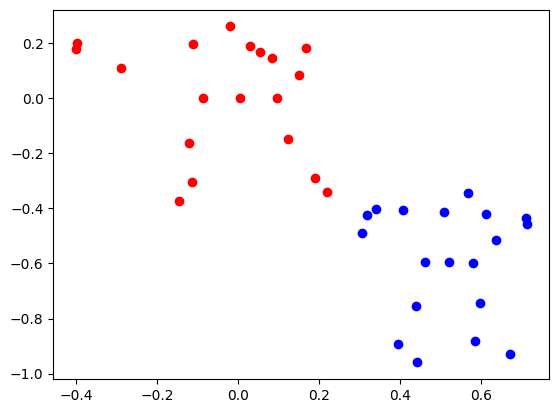

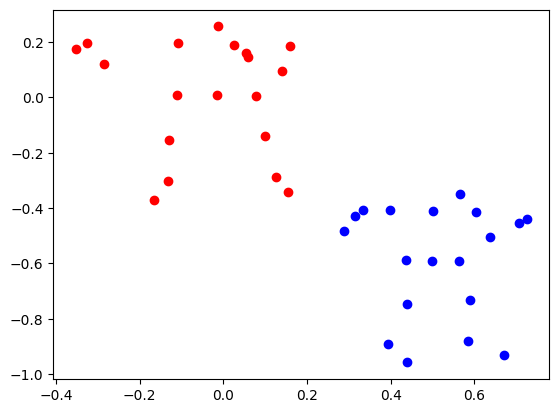

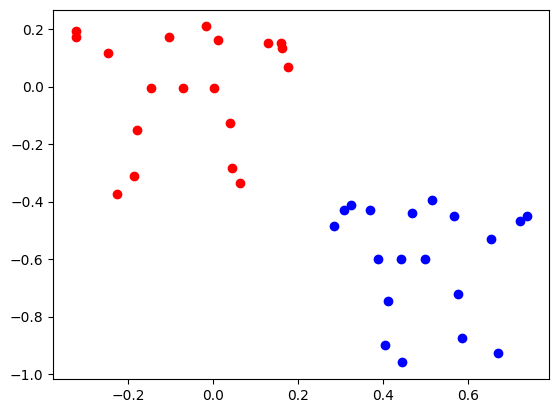

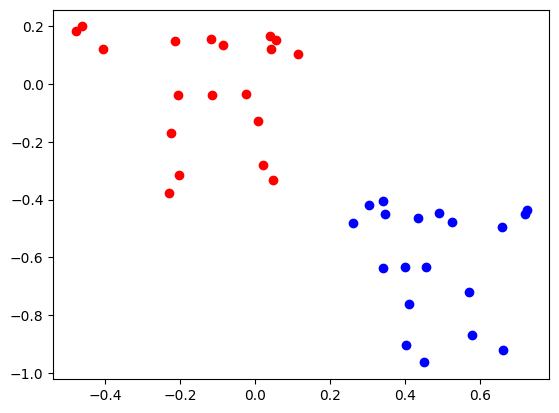

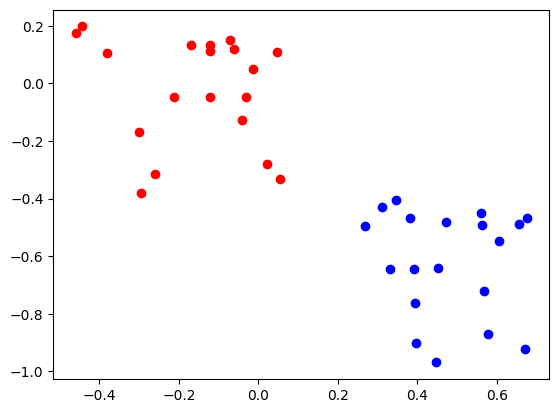

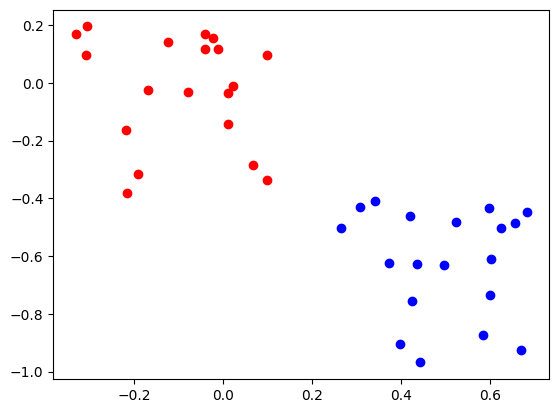

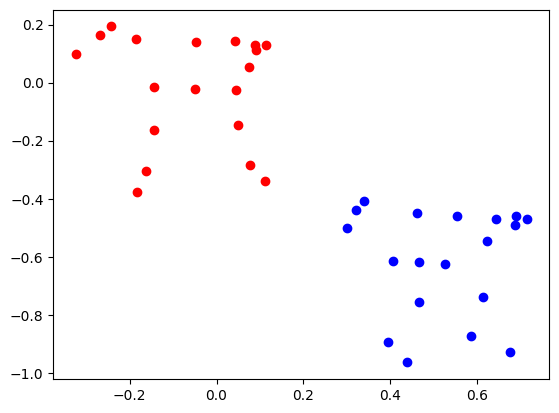

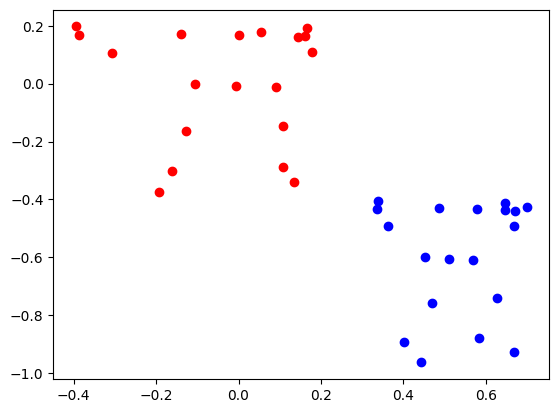

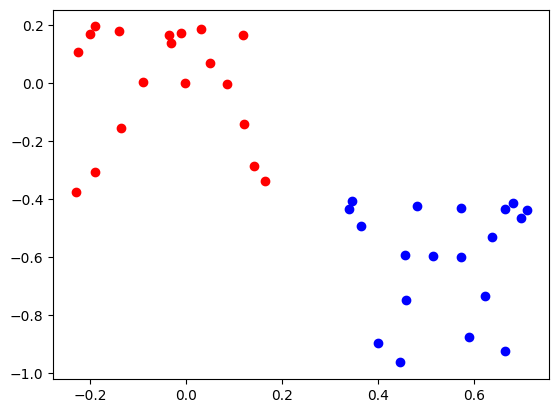

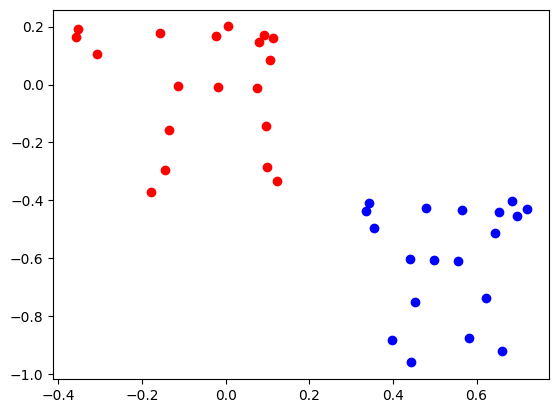

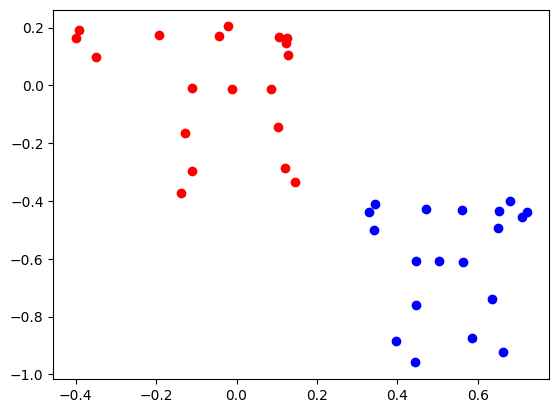

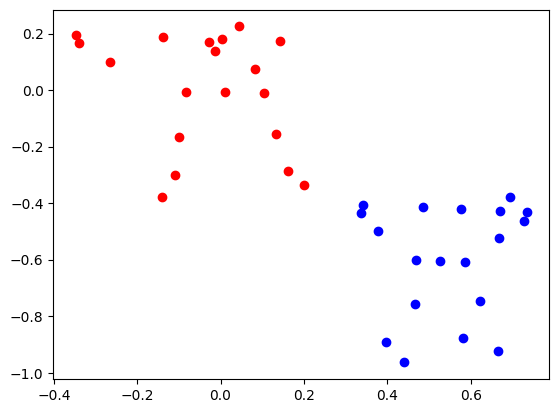

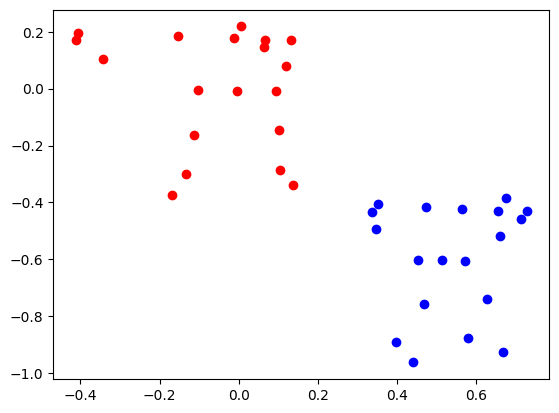

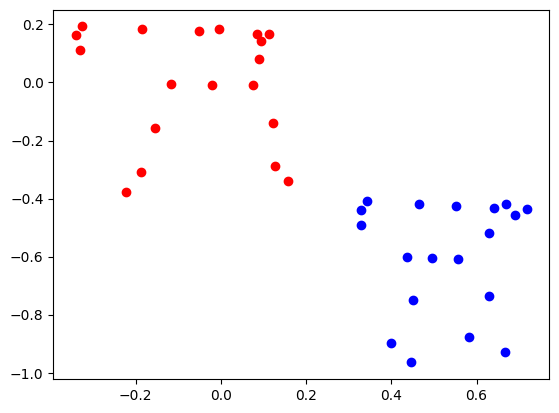

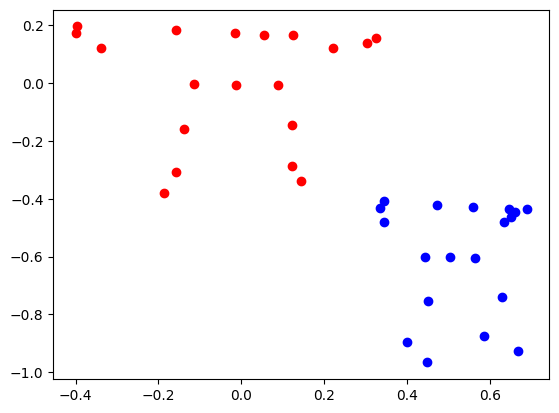

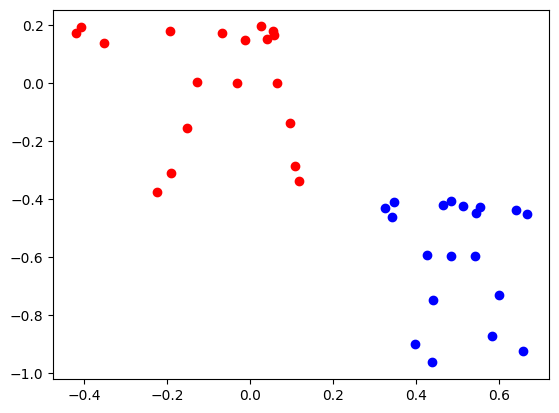

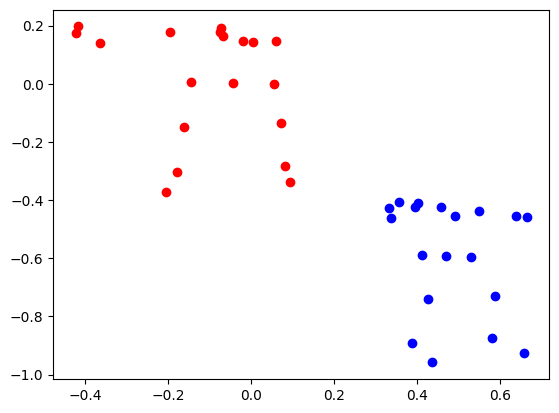

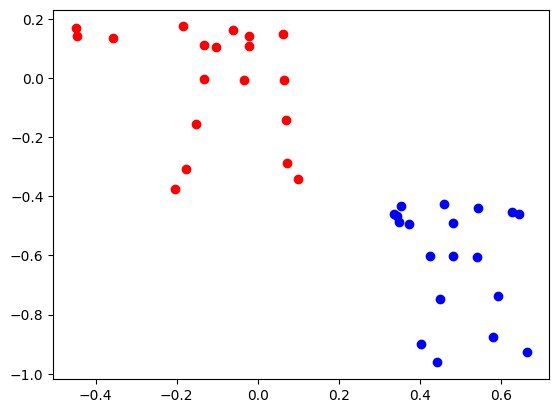

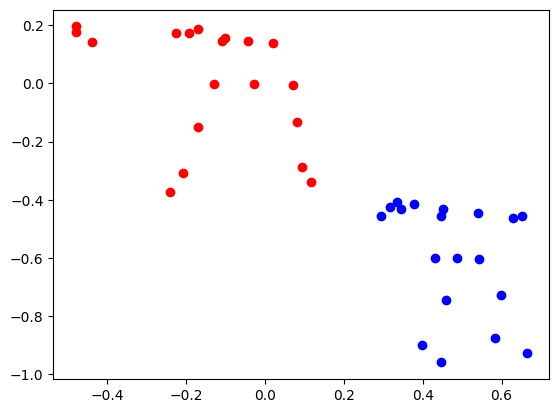

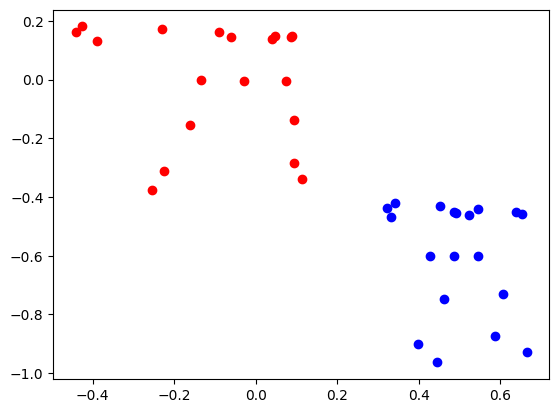

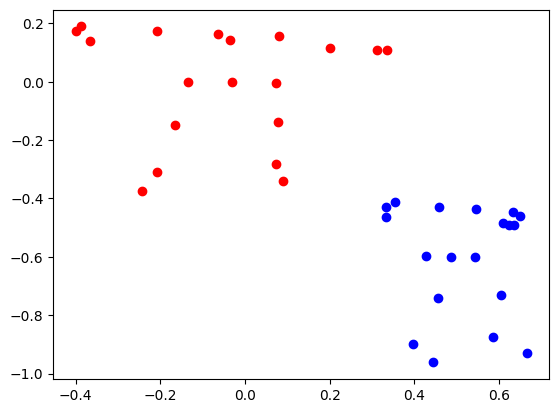

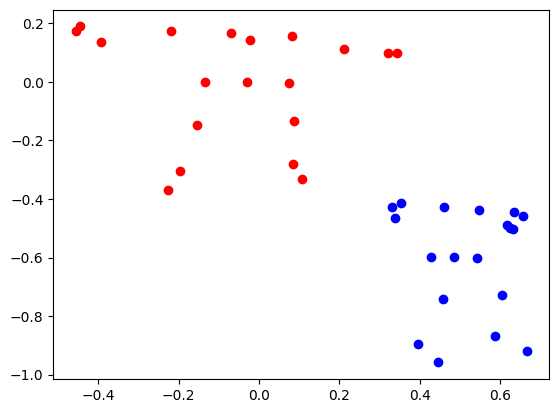

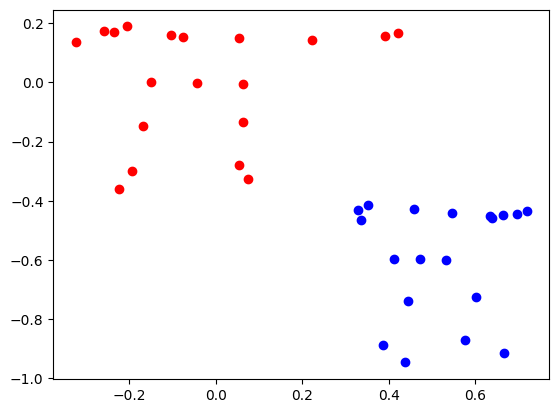

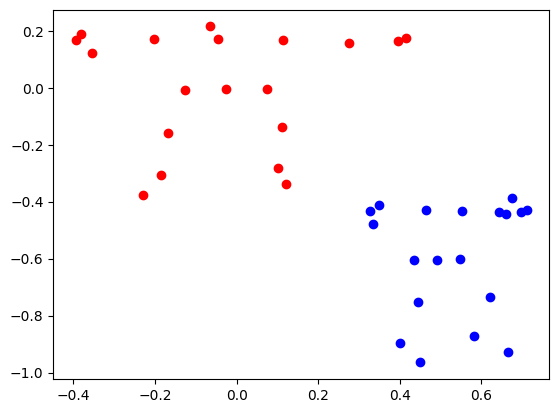

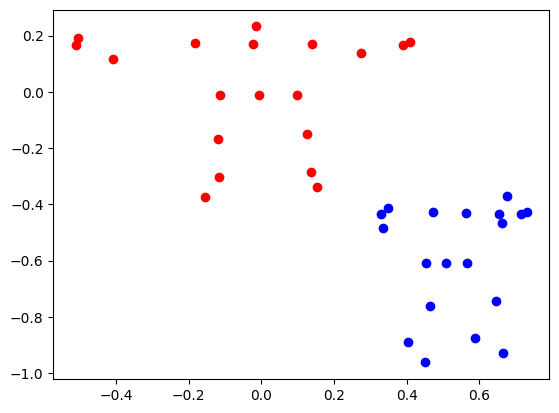

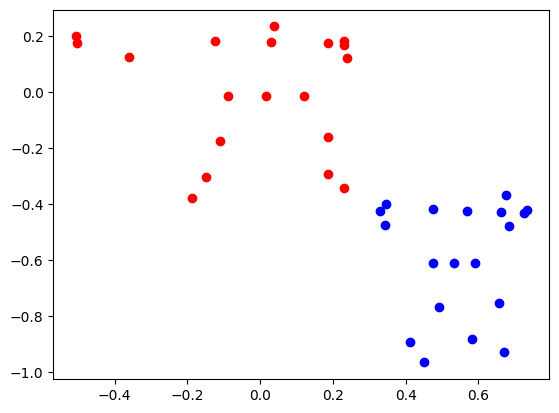

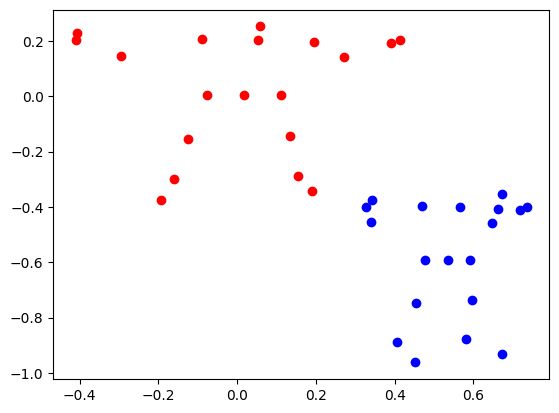

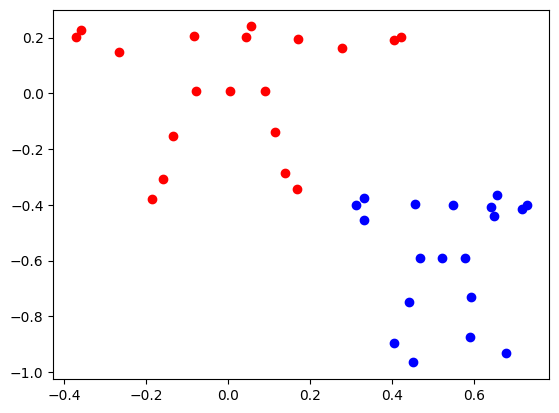

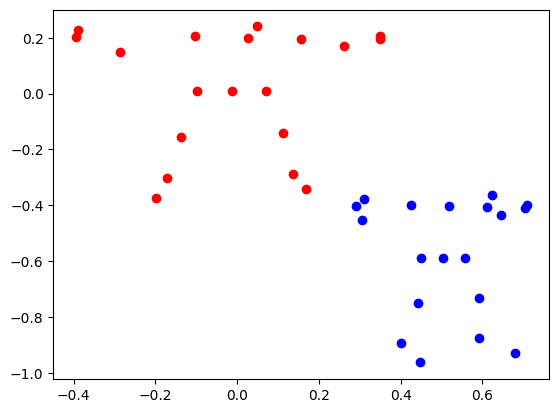

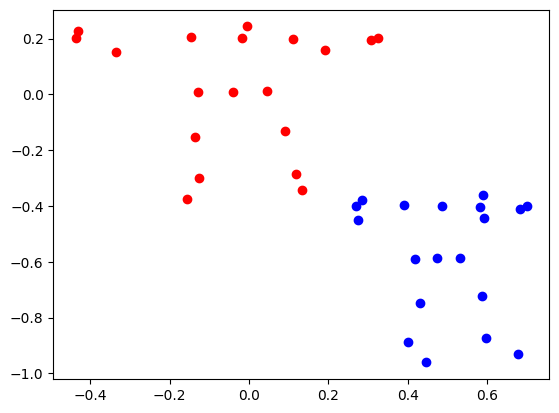

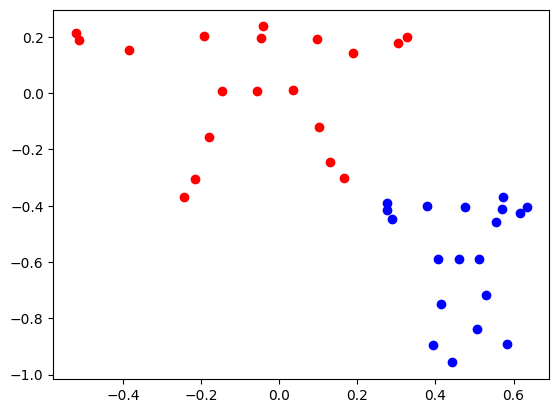

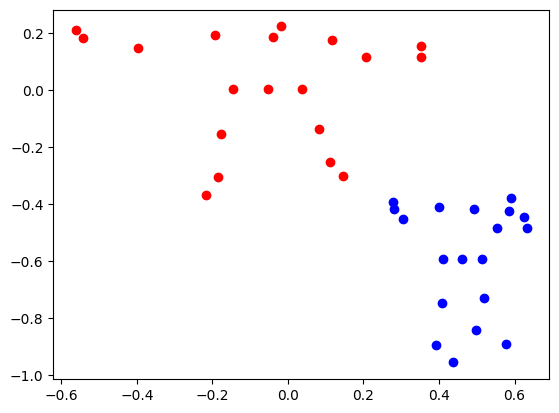

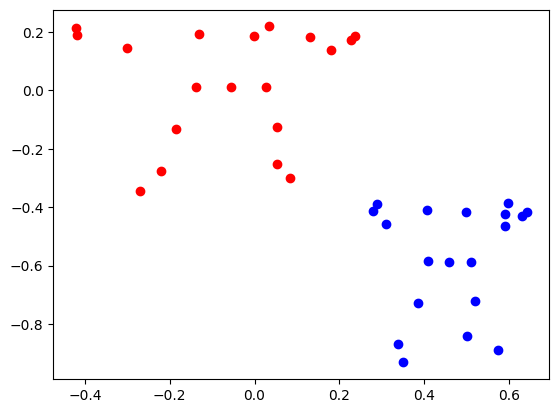

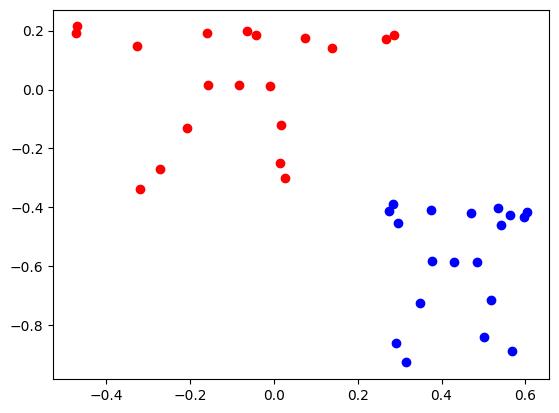

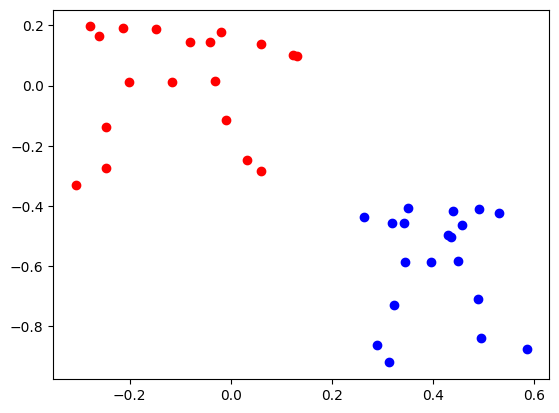

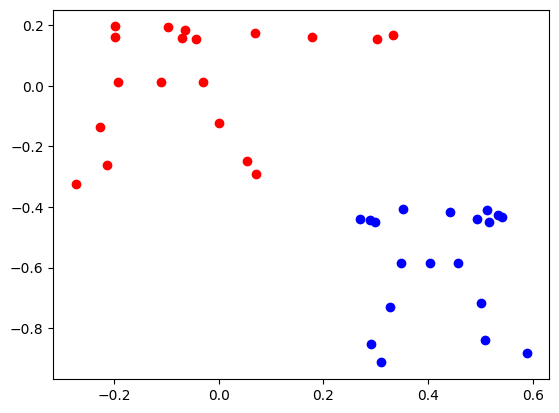

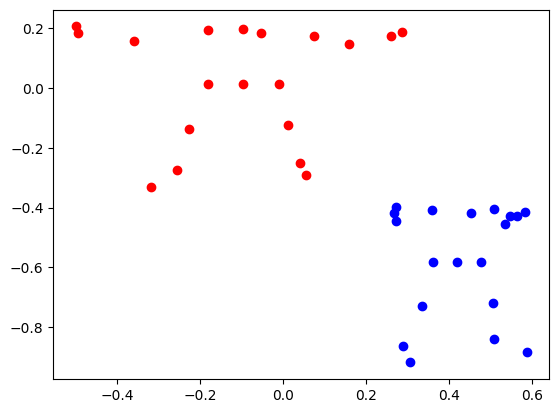

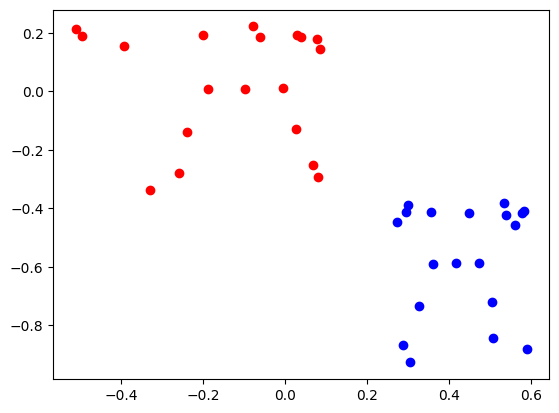

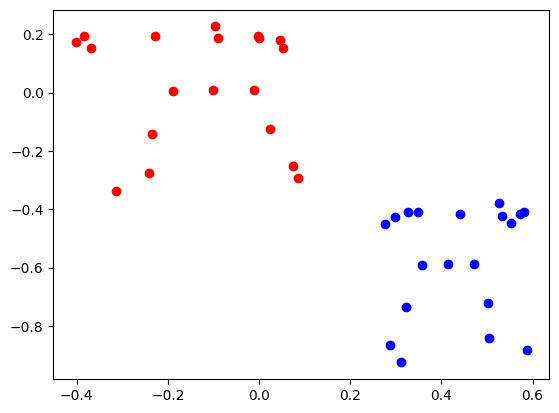

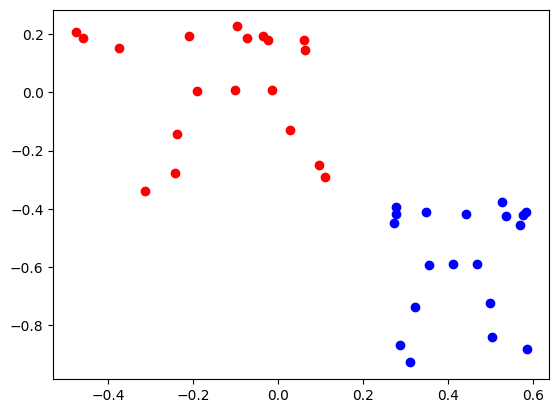

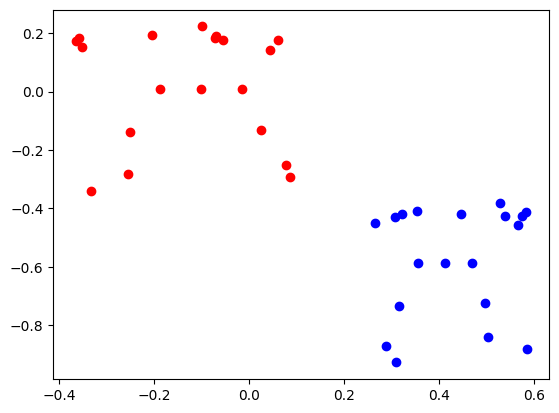

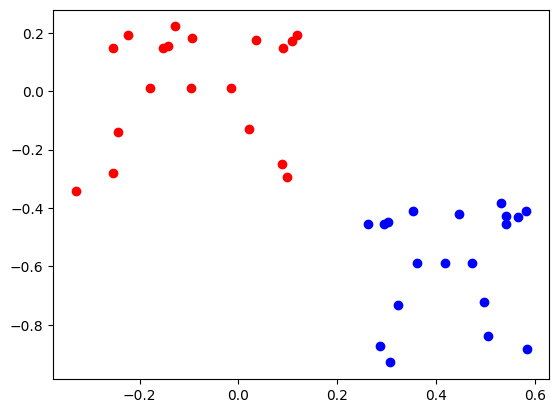

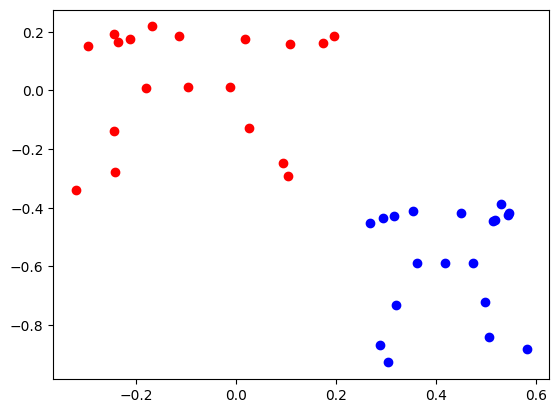

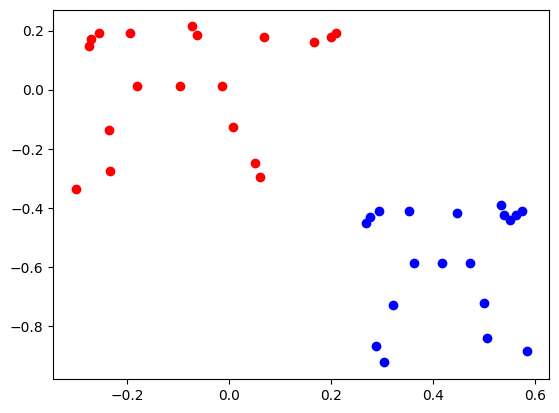

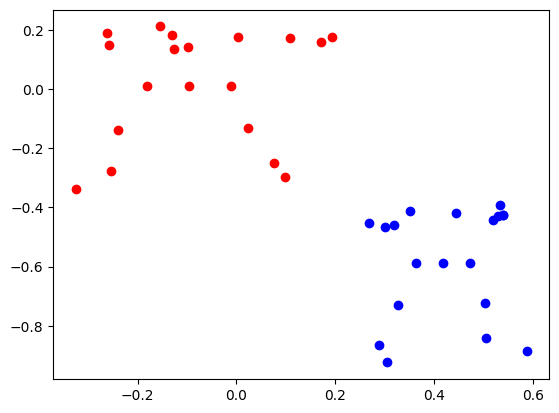

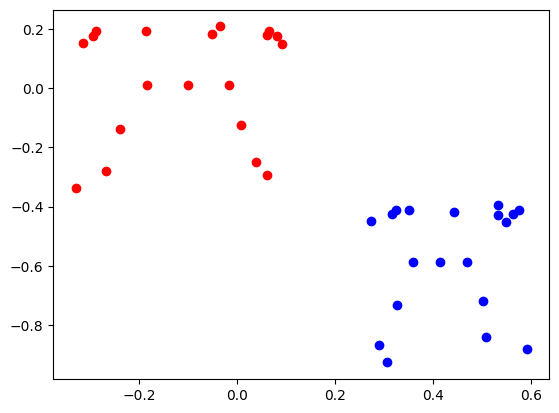

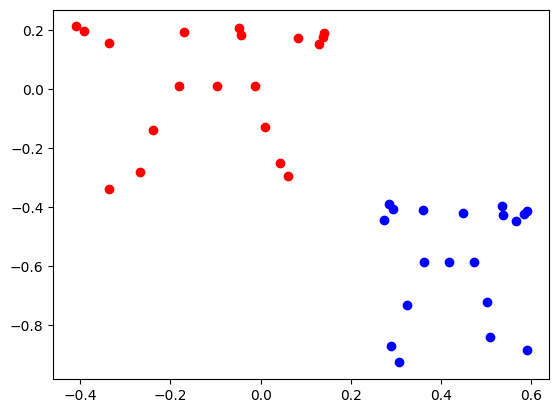

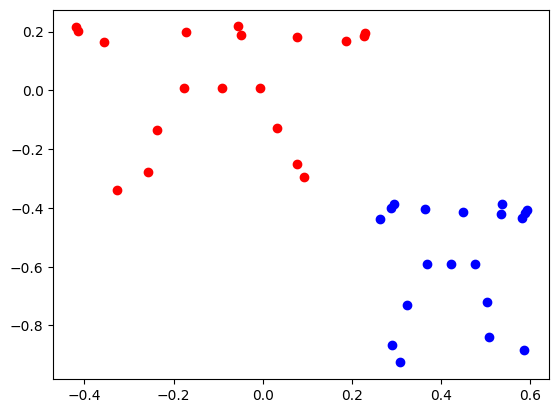

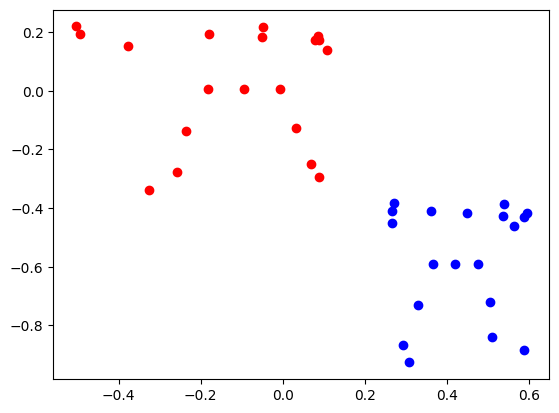

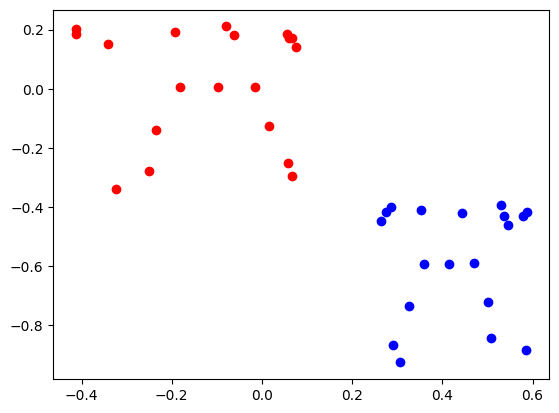

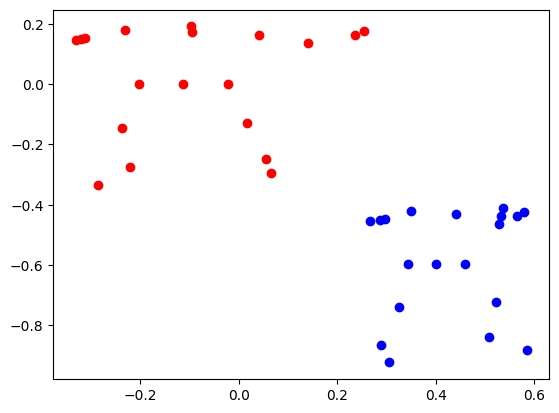

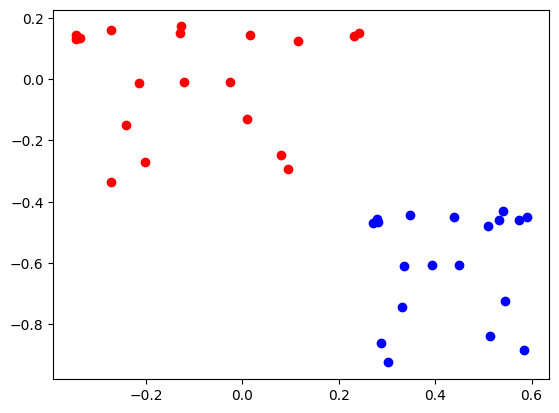

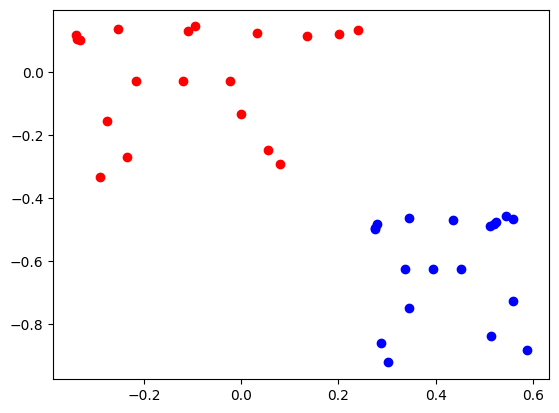

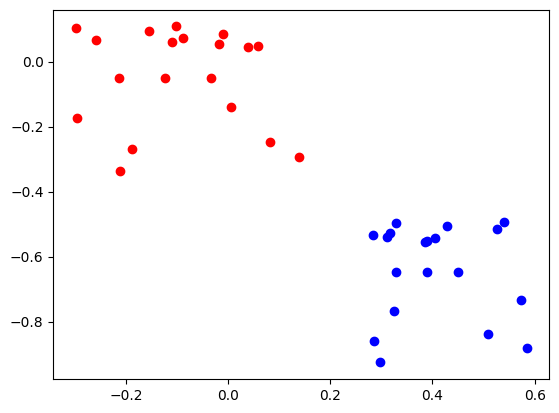

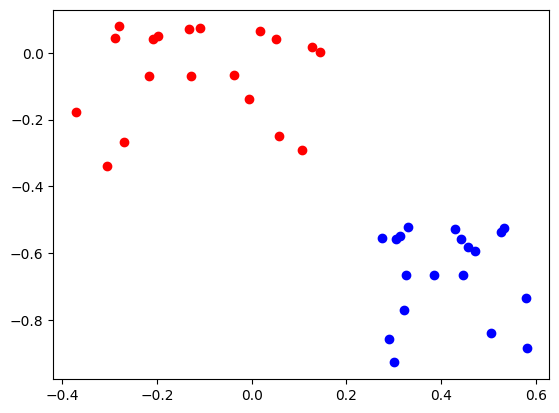

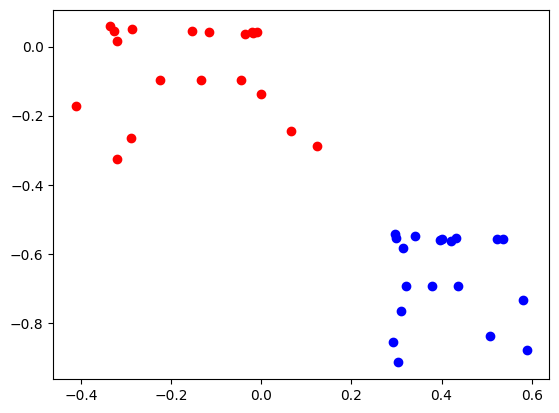

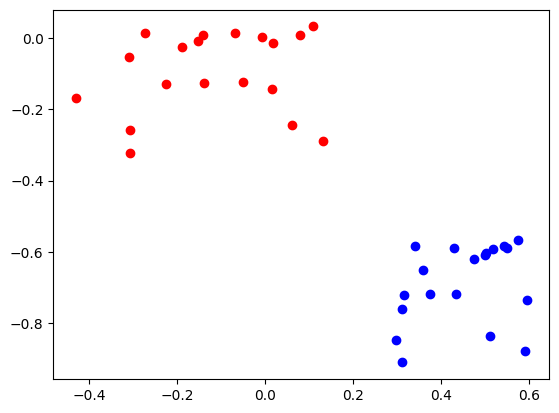

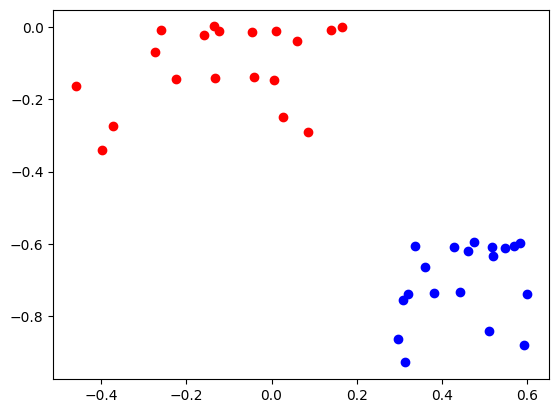

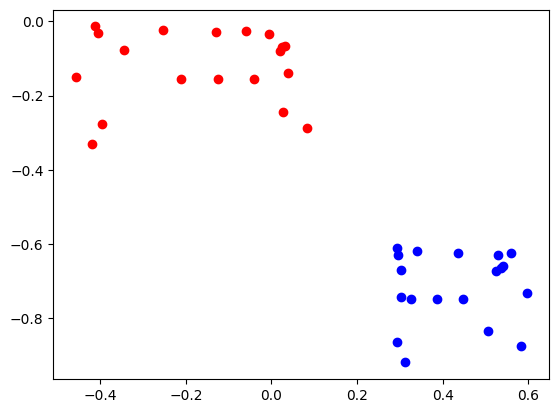

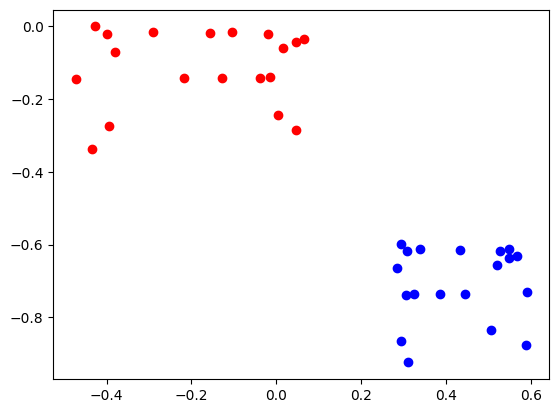

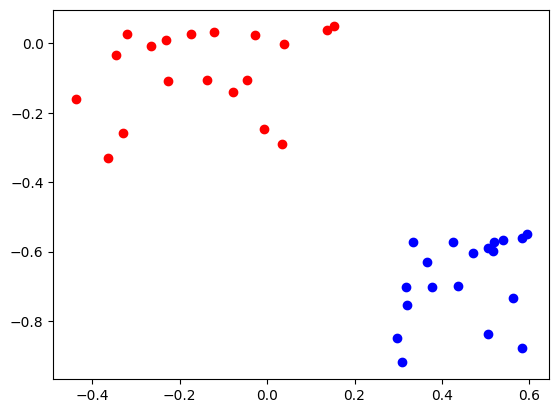

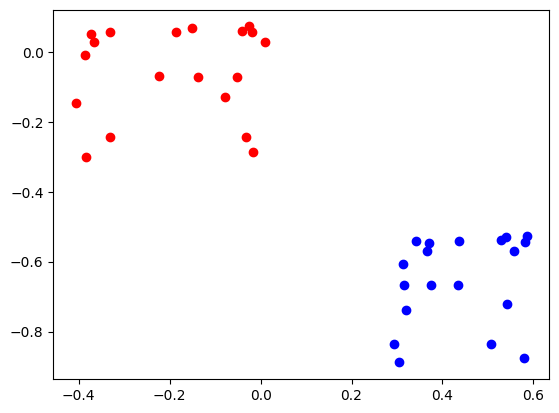

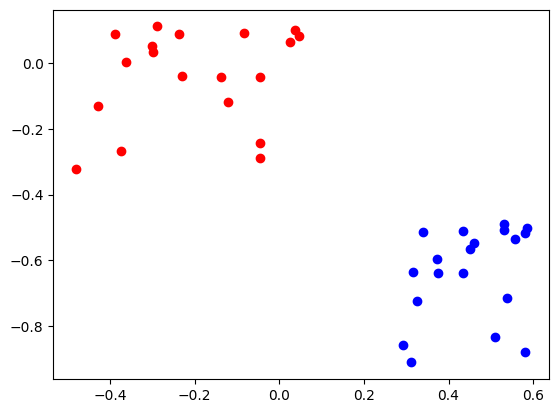

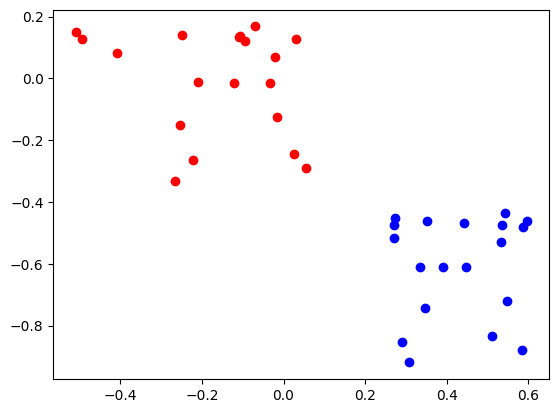

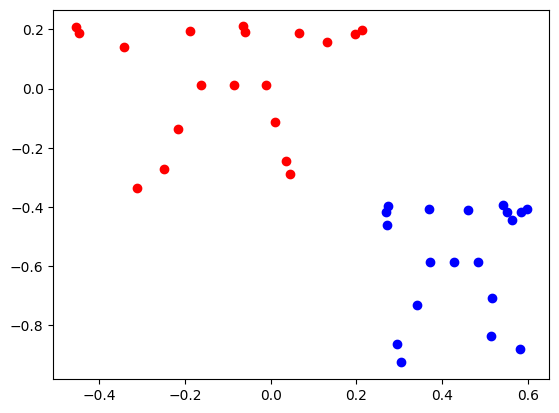

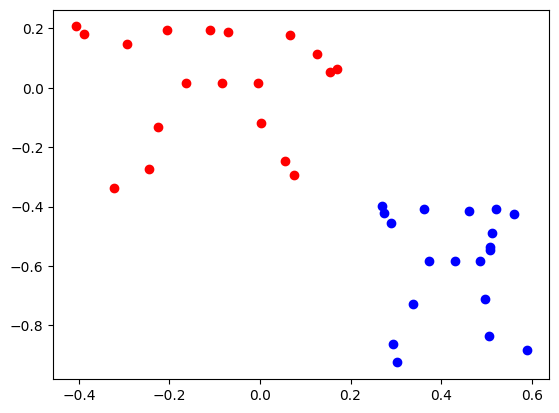

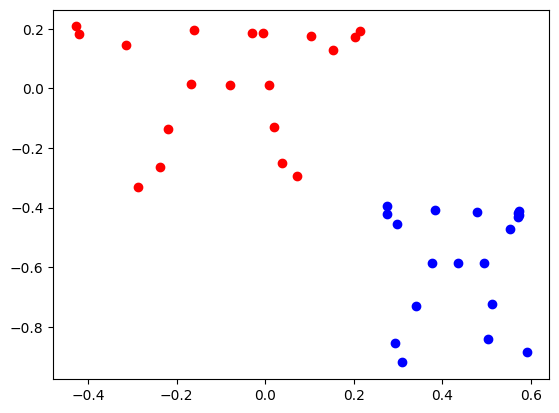

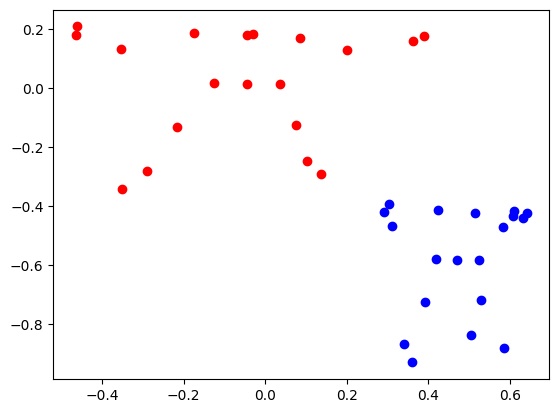

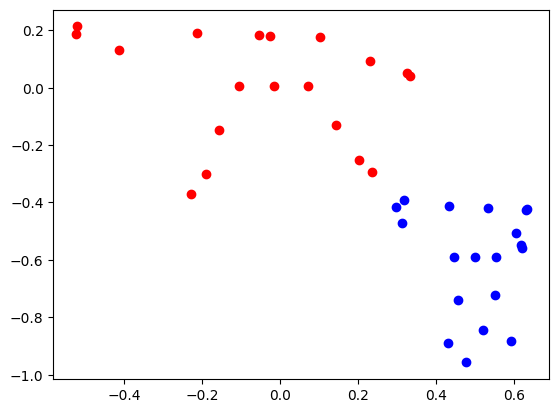

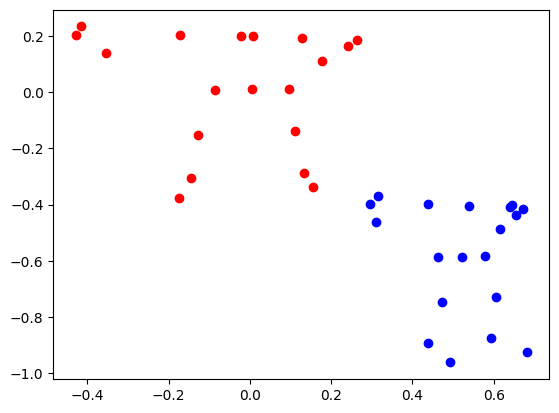

In [12]:
for frame in range(1, 750, 10):
    df = dataframe.iloc[:, 2:]
    df = df.iloc[frame, [col_idx for col_idx in range(df.shape[1]) if col_idx % 3 != 2]]
    data = df.to_numpy().reshape((19, -1))


    df2 = dataframe2.iloc[:, 2:]
    df2 = df2.iloc[frame, [col_idx for col_idx in range(df2.shape[1]) if col_idx % 3 != 2]]
    data2 = df2.to_numpy().reshape((19, -1))

    x = data[:, 0]
    y = data[:, 1]
    plt.scatter(x, -y, marker='o', color='blue')

    x2 = data2[:, 0]
    y2 = data2[:, 1]
    plt.scatter(x2, -y2, marker='o', color='red')

    plt.show()

In [186]:
custom_pose = CustomPoseLandmark(mp_pose, values, landmarks)

source = Path('../data/raw/squat/movie_01.mp4')
dataframe = prepare_dataframe(custom_pose)
dataframe2 = prepare_dataframe(custom_pose)
Id = source.name.split('.')[0]
time = 0 
cap = cv2.VideoCapture(source.__str__())


with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    enable_segmentation=False
) as pose:
    while cap.isOpened():
        ret, image = cap.read()
        if ret:
            time += 1
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            landmark_list = get_custom_landmarks(
                mp_pose=mp_pose,
                custom_pose=custom_pose,
                landmarks=results.pose_landmarks,
                custom_landmarks=list(custom_pose.custom_landmarks.keys()))
        

            record = [Id, time]
            
            # Create record containing video id, actual time and pose landmark coordinates
            for landmark in landmark_list.landmark:
                # Extract pose landmarks coordinates and store as array
                coordinates = landmark2array(landmark)[:3]
                record += coordinates.tolist()

            # Save collected data in DataFrame format
            dataframe = pd.concat(
                [dataframe, pd.DataFrame([record], columns=dataframe.columns)],
                ignore_index=True
            )

##########################################################################
            
            # rotation
            # roll, pitch yaw axes

            default_position = np.array([1, 0, 1])

            left_hip = landmark2array(
                landmark_list.landmark[
                    custom_pose.get_value(mp_pose.PoseLandmark.LEFT_HIP.value)
                ])[:3]

            right_hip = landmark2array(
                landmark_list.landmark[
                    custom_pose.get_value(mp_pose.PoseLandmark.RIGHT_HIP.value)
                ])[:3]
            
            position = left_hip - right_hip


            def calculate_angle(vector1, vector2):
                """
                
                """
                #
                cos_theta = min(
                    1, max(
                        -1, np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
                    )
                )

                return np.arccos(cos_theta)


            theta = -calculate_angle(default_position, position)
            
            def rotation(coordinates, theta):
                rotation_matrix = np.array(
                    [
                        [math.cos(theta), 0, math.sin(theta)],
                        [0, 1, 0],
                        [-math.sin(theta), 0, math.cos(theta)],
                    ]
                )
                return np.dot(rotation_matrix, coordinates)
            
                
####################################
            
            # translacja

            default_point = np.zeros(shape=(3,))

            # translation vector
            pelvis = landmark2array(
                landmark_list.landmark[
                    custom_pose.get_value('PELVIS')
                ])[:3]

            vector = default_point - pelvis

            def translation(coordinates, vector):
                return coordinates + vector



####################################

            # skalowanie

            default_length = 0.25

            left_hip = landmark2array(
                landmark_list.landmark[
                    custom_pose.get_value(mp_pose.PoseLandmark.LEFT_HIP.value)
                ])[:3]

            right_hip = landmark2array(
                landmark_list.landmark[
                    custom_pose.get_value(mp_pose.PoseLandmark.RIGHT_HIP.value)
                ])[:3]

            hip_length = np.linalg.norm(left_hip - right_hip)

            scale_factor = default_length / hip_length

            def scaling(coordinates, scale_factor):
                return scale_factor * coordinates


            
            record2 = [Id, time]
            
            # Create record containing video id, actual time and pose landmark coordinates
            for landmark in landmark_list.landmark:
                # Extract pose landmarks coordinates and store as array
                coordinates = landmark2array(landmark)[:3]
                # rotation
                coordinates = rotation(coordinates, theta)
                # translation
                coordinates = translation(coordinates, vector)
                # scaling
                coordinates = scaling(coordinates, scale_factor)

                record2 += coordinates.tolist()

            # Save collected data in DataFrame format
            dataframe2 = pd.concat(
                [dataframe2, pd.DataFrame([record2], columns=dataframe2.columns)],
                ignore_index=True
            )


            

############################################################################       
            
        else:
            break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

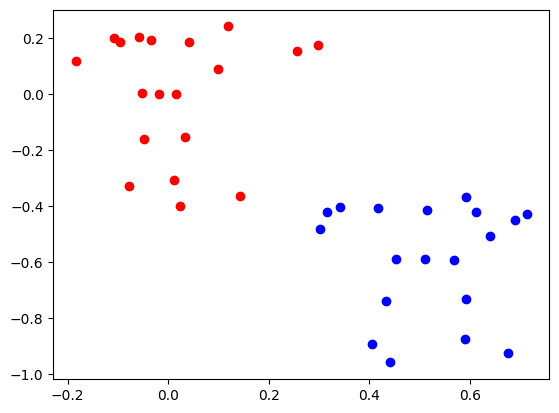

In [188]:
frame = 25

df = dataframe.iloc[:, 2:]
df = df.iloc[frame, [col_idx for col_idx in range(df.shape[1]) if col_idx % 3 != 2]]
data = df.to_numpy().reshape((19, -1))


df2 = dataframe2.iloc[:, 2:]
df2 = df2.iloc[frame, [col_idx for col_idx in range(df2.shape[1]) if col_idx % 3 != 2]]
data2 = df2.to_numpy().reshape((19, -1))

x = data[:, 0]
y = data[:, 1]
plt.scatter(x, -y, marker='o', color='blue')

x2 = data2[:, 0]
y2 = data2[:, 1]
plt.scatter(x2, -y2, marker='o', color='red')

plt.show()